## Phase 2 - EDA + Machine Learning with XGB
- More information - Phase 0 (Business Requirement) and Phase 1 (EDA using Python)

- In this Notebook we will do more exploratory data analysis and execute machine learning algorithms

- At the end is going to be provided a summary analysis and expected to answer the business questions (phase 0)


###  Prediction of Revenue in 2008


#### Packages used in this Notebook
- tidyverse
- xgboost
- Ckmeans.1d.dp
- caret
- MLmetrics

- to install a package just run the command for example: 
install.packages('MLmetrics')

In [2]:
library(tidyverse)
library(xgboost)

## Info - dataset

- the public dataset used in this process can be accessed trought IBM website below

https://www.ibm.com/communities/analytics/watson-analytics-blog/guide-to-sample-datasets/

In [3]:
df <- read_csv('../data/WA_Retail-SalesMarketing_-ProfitCost.csv')

## remove records without revenue
df <- na.omit(df)

## Columns used for prediction
col_revenue <- c(
  'Year'
  , 'Product line'
  , 'Product type'
  , 'Product'
  , 'Order method type'
  , 'Retailer country'
  , 'Revenue')


df <- df[col_revenue]

df %>% head(5) 

Parsed with column specification:
cols(
  Year = col_integer(),
  `Product line` = col_character(),
  `Product type` = col_character(),
  Product = col_character(),
  `Order method type` = col_character(),
  `Retailer country` = col_character(),
  Revenue = col_double(),
  `Planned revenue` = col_double(),
  `Product cost` = col_double(),
  Quantity = col_integer(),
  `Unit cost` = col_double(),
  `Unit price` = col_double(),
  `Gross profit` = col_double(),
  `Unit sale price` = col_double()
)


Year,Product line,Product type,Product,Order method type,Retailer country,Revenue
2004,Camping Equipment,Cooking Gear,TrailChef Water Bag,Telephone,United States,315044.33
2004,Camping Equipment,Cooking Gear,TrailChef Water Bag,Telephone,Canada,13444.68
2004,Camping Equipment,Cooking Gear,TrailChef Water Bag,Telephone,Japan,181120.24
2004,Camping Equipment,Cooking Gear,TrailChef Water Bag,Telephone,China,69608.15
2004,Camping Equipment,Cooking Gear,TrailChef Water Bag,Telephone,Singapore,30940.35


### Basic information / distribution of the data

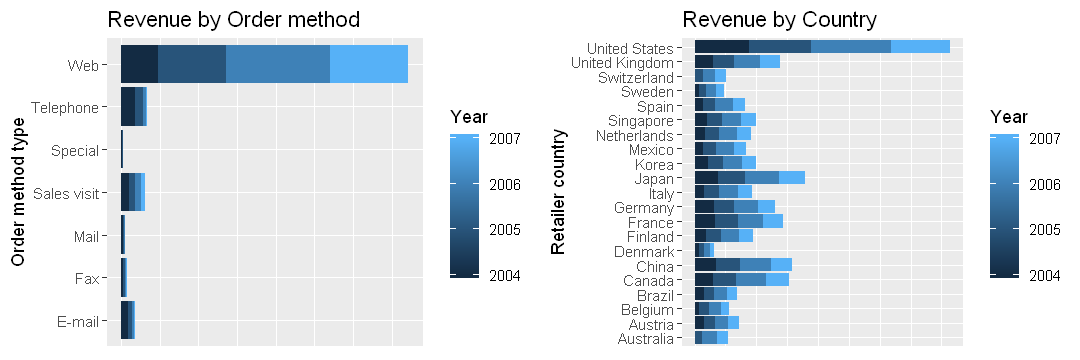

In [4]:
df <- df %>% mutate_if(is.character, as.factor)

options(repr.plot.width = 9, repr.plot.height = 3)
gg1 <- qplot(data=df, x=`Order method type`, y=Revenue, geom='col', fill=Year, main = 'Revenue by Order method' ) +
  scale_y_continuous(name="Revenue", labels = scales::comma) + coord_flip()  +
  theme(axis.title.x=element_blank(),
        axis.text.x=element_blank(),
        axis.ticks.x=element_blank())

gg2 <- qplot(data=df, x=`Retailer country`, y=Revenue, geom='col', fill=Year, main = 'Revenue by Country'  ) +
  scale_y_continuous(name="Revenue", labels = scales::comma) + coord_flip()  +
  theme(axis.title.x=element_blank(),
        axis.text.x=element_blank(),
        axis.ticks.x=element_blank())

gridExtra::grid.arrange(gg1, gg2, nrow = 1)

### Analyze Revenue by Product line with Year distribution

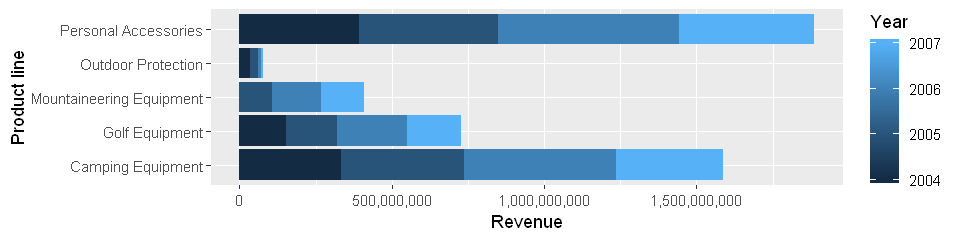

In [5]:
options(repr.plot.width = 8, repr.plot.height = 2)

## revenue by product line by year
qplot(data=df, x=`Product line`, y=Revenue, geom='col', fill=Year) +
  scale_y_continuous(name="Revenue", labels = scales::comma) + coord_flip()


#### 1st Note
- Personal Accessories and Camping Equipment tend to have higher revenue that other Product lines

- Web method provide the biggest revenues

- United States country also provide the biggest revenue

### Distribution of the Revenue and evaluation of possible outliers

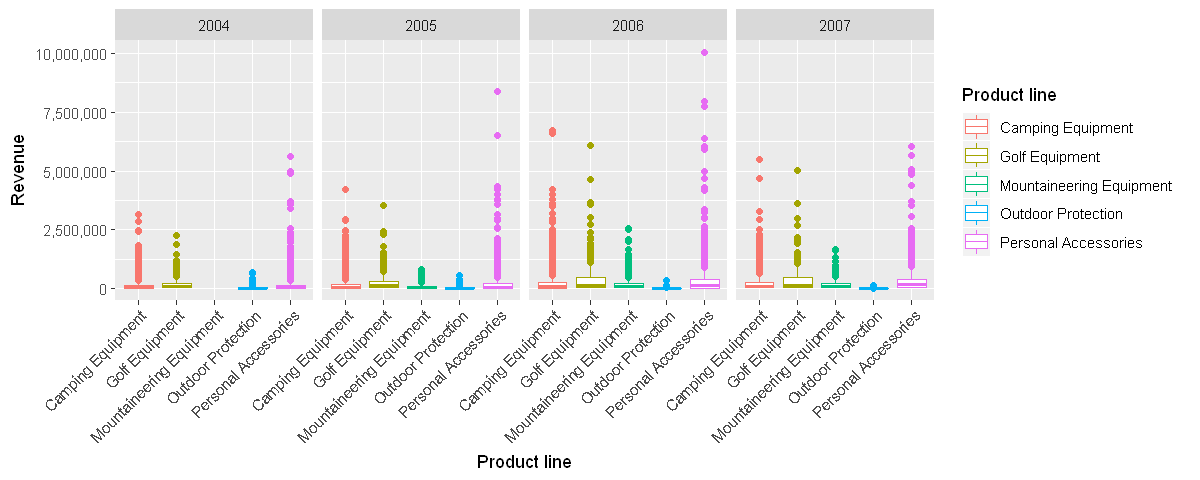

In [6]:
options(repr.plot.width = 10, repr.plot.height = 4)
qplot(data=df, x=`Product line`, y=Revenue, geom='boxplot', color=`Product line`, facets = ' Year ~ .') +
  scale_y_continuous(name="Revenue", labels = scales::comma)  + ## mediana = 163000
  theme(axis.text.x = element_text(angle = 45, hjust = 1))

### 2nd Note

- Personal Accessories and Camping Equipment have more outliers with higher value in Year 2006

- Let's confirm the Total Revenue by Year (2006) and it's impact related to others


### Info

- this type of scenario (higher revenue for specific items on specific year) must be better understanding with Line of Business Managers and also evaluate if it was just a sazonal discrepancie or some marketing campaign or business decision have bigger influence on these numbers


- Another important point to understand are related on how it can influence the prediction of the revenue for year 2008


## Total Revenue by Year

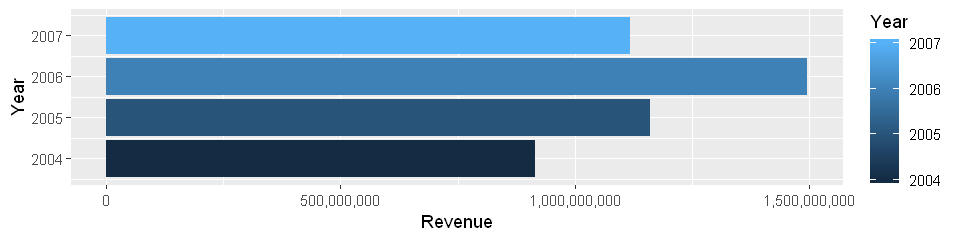

In [7]:
## revenue by year -> fazer a simulacao/modelo somente com estes dados
options(repr.plot.width = 8, repr.plot.height = 2)
qplot(data=df, x=Year, y=Revenue, geom='col', fill=Year)+
  scale_y_continuous(name="Revenue", labels = scales::comma) + coord_flip()


## Start the Prediction of Revenue for year - 2008

- Will be used XGBoost to predict the revenue in 2008
- Use Caret to partition the train and test data
- Compare the results achieved with XGB vs Random Forest in Phase 1

#### Aditional info
- Were not provided one dataset by the business users related to year 2008

#### XGBoost documentation and samples: 

https://xgboost.readthedocs.io/en/latest/ 

https://github.com/dmlc/xgboost

In [8]:
## define the target and prepare the data to run XGB
target <- 'Revenue'
idx_target <- which(col_revenue == target)

dfxgb <- df %>% mutate_if(is.character, as.factor)
dfxgb <- dfxgb %>% mutate_if(is.factor, as.integer)

set.seed(12345)
idx <- caret::createDataPartition(dfxgb$Revenue, p=0.80, list=FALSE)
train <- dfxgb[idx, ]
test <- dfxgb[-idx, ]

dtrain <- xgb.DMatrix(data = as.matrix(train[, -idx_target]), label= train[[target]])
dtest <- xgb.DMatrix(data = as.matrix(test[, -idx_target]))

In [9]:
## execution of XGB
set.seed(12345)
fit.xgb <- xgboost(data = dtrain, 
                   objective = "reg:linear",
                   booster = "gbtree",
                   print_every_n = 25, ## print every 25
                   nrounds = 350) 


[1]	train-rmse:368519.000000 
[26]	train-rmse:161832.156250 
[51]	train-rmse:131686.859375 
[76]	train-rmse:110794.734375 
[101]	train-rmse:101309.117188 
[126]	train-rmse:92665.507812 
[151]	train-rmse:87156.484375 
[176]	train-rmse:83507.718750 
[201]	train-rmse:79411.625000 
[226]	train-rmse:75475.070312 
[251]	train-rmse:72690.914062 
[276]	train-rmse:70538.992188 
[301]	train-rmse:68313.281250 
[326]	train-rmse:66531.570312 
[350]	train-rmse:64893.933594 


### 3rd Note

- XGB have a lot of parameters to tune the algorithm as can be seen in the XGB documentation link provided above


- The printed result above shows the improvement of the trainning process at every 25 steps as detailed in print_every_n = 25, and use rmse evaluation metric

### Info
- The Random Forest Regressor/Phase_1 (Python - sklearn) use R^2 to evaluate the prediction and will be used also below to compare both metrics. Our target is to achieve R^2 near to 1



#### RMSE : Root Mean Squared Error

https://en.wikipedia.org/wiki/Root-mean-square_deviation

#### R^2 : Coeficient of determination

https://en.wikipedia.org/wiki/Coefficient_of_determination


    **  In regression, the R2 coefficient of determination is a statistical measure of how well the regression predictions approximate the real data points. An R2 of 1 indicates that the regression predictions perfectly fit the data


## Feature importance

#### Note
- the 3 most important features still the same (Product, Retailer country and Order method type) however with XGB the most import feature is Product


             Feature       Gain      Cover  Frequency
1:           Product 0.30438392 0.49273598 0.25324370
2:  Retailer country 0.23113830 0.22153642 0.30001880
3: Order method type 0.21003098 0.08815150 0.17826250
4:      Product type 0.10035484 0.09174638 0.06788266
5:              Year 0.07737424 0.07443256 0.15739000
6:      Product line 0.07671772 0.03139716 0.04320233


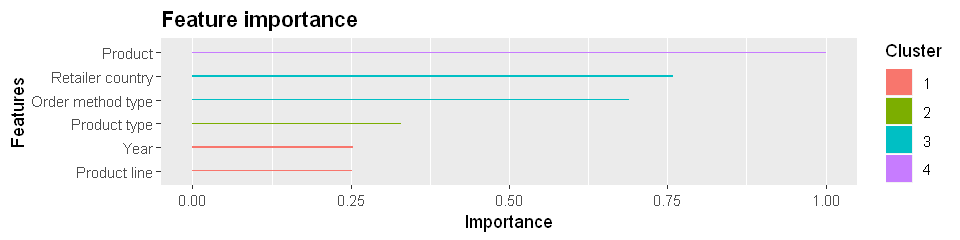

In [10]:
### feature importance
## importance variable of the xgb model
imp_features <- xgb.importance(model = fit.xgb)

print(imp_features)

## Plot Feature importance
xgb.ggplot.importance(imp_features, rel_to_first = TRUE)


#### Compare the prediction between XGB and Random Forest (Phase_1)

In [11]:
## Evaluate the prediction with test data
predict_xgb <- predict(fit.xgb, dtest)
predict_xgb <- ifelse(predict_xgb < 1, 0, predict_xgb)


## R^2 0.9016625 -> 90% -> 6% better than random forest python (84%)
print('---------------------------- R^2 evaluation')
print(MLmetrics::R2_Score(predict_xgb, test$Revenue))


[1] "---------------------------- R^2 evaluation"
[1] 0.9016625


### Important note
- The prediction provided by XGB achieve an R^2 of 0.9016625 and is 6% higher than Random Forest in Phase 1 (0.8442048767542322) and is a good improvement, so we can keep the prediction with XGB

- Let's move on and predict and evaluate the revenue for the year 2008

In [12]:
## The Business Requirement request to predict the revenue for 2008 but do not provide data for 2008

## the trick here => we will use the same products sold on 2007 to predict the Revenue for 2008 and evaluate the results
#### the model used have R^2 of 0.9016 so we expect to achieve a confident result

df_2008 <- dfxgb %>% filter(Year==2007)

## update Year to 2008 and setup the Revenue to 0 -> Revenue will be updated with the prediction later
df_2008$Year <- 2008
df_2008$Revenue <- 0

print('-------------------------------------- INITIAL dataset: 2008 YEAR')
print(summary(df_2008))

## gernerate the data to use with XGB model (fit.xgb)
xgb_2008 <- xgb.DMatrix(data = as.matrix(df_2008[, -idx_target]), label= df_2008[[target]])

predict_revenue_2018 <- predict(fit.xgb, xgb_2008)
predict_revenue_2018 <- ifelse(predict_revenue_2018 < 1, 0, predict_revenue_2018)

## update the Revenue predition for year 2008 and compare with other Years
df_2008$Revenue <- predict_revenue_2018

## generate one dataset to compare the revenue form all Years
df_all <- rbind(dfxgb, df_2008)

print('-------------------------------------- PREDICTION: 2008 YEAR')
summary(df_all)

[1] "-------------------------------------- INITIAL dataset: 2008 YEAR"
      Year       Product line    Product type      Product      
 Min.   :2008   Min.   :1.000   Min.   : 1.00   Min.   :  1.00  
 1st Qu.:2008   1st Qu.:1.000   1st Qu.: 4.00   1st Qu.: 36.00  
 Median :2008   Median :3.000   Median :10.00   Median : 68.00  
 Mean   :2008   Mean   :2.937   Mean   :10.64   Mean   : 70.36  
 3rd Qu.:2008   3rd Qu.:5.000   3rd Qu.:16.00   3rd Qu.:106.00  
 Max.   :2008   Max.   :5.000   Max.   :21.00   Max.   :144.00  
 Order method type Retailer country    Revenue 
 Min.   :1.000     Min.   : 1.00    Min.   :0  
 1st Qu.:4.000     1st Qu.: 6.00    1st Qu.:0  
 Median :7.000     Median :12.00    Median :0  
 Mean   :5.773     Mean   :11.57    Mean   :0  
 3rd Qu.:7.000     3rd Qu.:17.00    3rd Qu.:0  
 Max.   :7.000     Max.   :21.00    Max.   :0  
[1] "-------------------------------------- PREDICTION: 2008 YEAR"


      Year       Product line    Product type      Product      
 Min.   :2004   Min.   :1.000   Min.   : 1.00   Min.   :  1.00  
 1st Qu.:2005   1st Qu.:1.000   1st Qu.: 4.00   1st Qu.: 35.00  
 Median :2006   Median :3.000   Median :10.00   Median : 71.00  
 Mean   :2006   Mean   :2.951   Mean   :10.52   Mean   : 71.63  
 3rd Qu.:2007   3rd Qu.:5.000   3rd Qu.:16.00   3rd Qu.:109.00  
 Max.   :2008   Max.   :5.000   Max.   :21.00   Max.   :144.00  
 Order method type Retailer country    Revenue        
 Min.   :1.000     Min.   : 1.00    Min.   :       0  
 1st Qu.:4.000     1st Qu.: 6.00    1st Qu.:   19549  
 Median :6.000     Median :11.00    Median :   65002  
 Mean   :5.309     Mean   :11.46    Mean   :  197870  
 3rd Qu.:7.000     3rd Qu.:17.00    3rd Qu.:  207914  
 Max.   :7.000     Max.   :21.00    Max.   :10054289  

### Evalute the Revenue Prediction for 2008

- Info: The Revenue for 2008 Year are predictions and from 2004 to 2007 are real Revenue

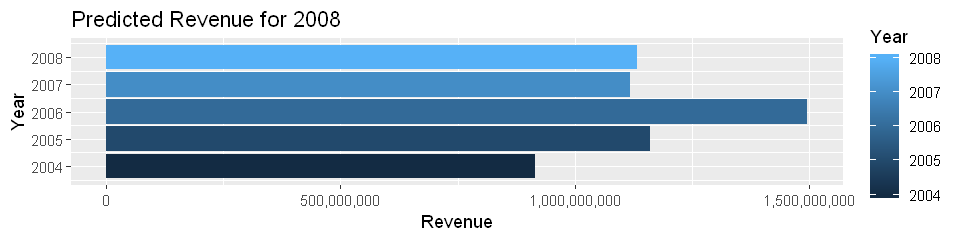

In [13]:
## info: 2008 is the Revenue Prediction
qplot(data=df_all, x=Year, y=Revenue, geom='col', fill=Year, main='Predicted Revenue for 2008')+
  scale_y_continuous(name="Revenue", labels = scales::comma) + coord_flip()


In [14]:
## Revenue by Year
revenue_by_year <- df_all %>% group_by(Year) %>% summarise(Total_Revenue = sum(Revenue))

print(revenue_by_year)

# A tibble: 5 x 2
   Year Total_Revenue
  <dbl>         <dbl>
1  2004    914352804.
2  2005   1159195590.
3  2006   1495891101.
4  2007   1117336274.
5  2008   1132382363.


## Insights

- The revenue prediction for the year 2008 is bigger than 2007 and smaller than the year 2005


- The higher revenue of year 2006 seems to not impact the prediction of the revenue for 2008
        => the higher outliers exposed in the boxplot chart seems to not impact in the revenue prediction


- The confidence of this prediction is quite high so let's answer the final business questions
    -  what are the divergence expected on revenue in 2008 ?

### Analysis - Revenue Prediction of 2008 vs (2005 and 2007)

In [15]:
rev_2008_vs_2005 <- round( (revenue_by_year[revenue_by_year$Year==2008, 'Total_Revenue'] / 
                            revenue_by_year[revenue_by_year$Year==2005, 'Total_Revenue']) * 100  , 2)

rev_2008_vs_2007 <- round( (revenue_by_year[revenue_by_year$Year==2008, 'Total_Revenue'] / 
                            revenue_by_year[revenue_by_year$Year==2007, 'Total_Revenue']) * 100  , 2)

print(' -------------- Revenue 2008 vs 2005 ')
colnames(rev_2008_vs_2005) <- 'Percent Revenue_2008_vs_2005'
rev_2008_vs_2005

print(' -------------- Revenue 2008 vs 2007 ')
colnames(rev_2008_vs_2007) <- 'Percent Revenue_2008_vs_2007'
rev_2008_vs_2007

[1] " -------------- Revenue 2008 vs 2005 "


Percent Revenue_2008_vs_2005
97.69


[1] " -------------- Revenue 2008 vs 2007 "


Percent Revenue_2008_vs_2007
101.35


## Summary

- Answers for the Business Requirement


### The revenue prediction for year 2008 can be done and the 3 most important features to predict revenue are
- Product
- Retailer country and
- Order method type


### The prediction confidence is high
- Achieved an R^2 of 0.9016 and we can fill confident with the prediction numbers


### The divergence related to the revenue prediction are

** Based on the assumption to sell the same products of the year 2007

- Revenue prediction for 2008 are expected to be 2.5% smaller than the year 2005 and

- Revenue prediction for 2008 are expected to be 1.5% higher than the last year (year 2007)

In [16]:
print('----------------  THE END')

[1] "----------------  THE END"
